In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adeshpal/rain-100l")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/rain-100l


In [ ]:
input='/root/.cache/kagglehub/datasets/adeshpal/rain-100l/versions/1/Rain100L/input',
target='/root/.cache/kagglehub/datasets/adeshpal/rain-100l/versions/1/Rain100L/target',

In [ ]:
# If you’re in a notebook
%pip install pytorch-msssim


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SRB(nn.Module):
    """Shallow Residual Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1)
        )

    def forward(self, x):
        return x + self.conv(x)

class SAM(nn.Module):
    """Spatial Attention Module"""
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, 7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        combined = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(combined))
        return x * attention

class CAM(nn.Module):
    """Channel Attention Module"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, _, _ = x.size()
        avg_out = self.mlp(self.avg_pool(x).view(B, C))
        max_out = self.mlp(self.max_pool(x).view(B, C))
        channel_attention = self.sigmoid(avg_out + max_out).view(B, C, 1, 1)
        return x * channel_attention

class CCALayer(nn.Module):
    """Contrast-aware Channel Attention Layer"""
    def __init__(self, channels):
        super().__init__()
        self.contrast = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.contrast(x)

class ERFDB(nn.Module):
    """Enhanced Residual Feature Distillation Block"""
    def __init__(self, channels, num_srbs=2):
        super().__init__()
        self.srbs = nn.Sequential(*[SRB(channels) for _ in range(num_srbs)])
        self.sam = SAM()
        self.cam = CAM(channels)
        self.cca = CCALayer(channels)
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        residual = x
        x = self.srbs(x)
        x = self.sam(x)
        x = self.cam(x)
        x = self.cca(x)
        x = self.conv(x)
        return x + residual

class MultiScaleERFDB(nn.Module):
    """Multi-Scale ERFDB processing parallel ERFDBs at different resolutions"""
    def __init__(self, channels, scales=(1, 0.5, 0.25), num_srbs=2):
        super().__init__()
        self.scales = scales
        self.erfdbs = nn.ModuleList([ERFDB(channels) for _ in scales])

    def forward(self, x):
        # Generate multi-scale feature maps and process through ERFDBs
        outputs = []
        for scale, erfdb in zip(self.scales, self.erfdbs):
            if scale != 1:
                small = F.interpolate(x, scale_factor=scale, mode='bilinear', align_corners=False)
                out_small = erfdb(small)
                out = F.interpolate(out_small, size=x.shape[2:], mode='bilinear', align_corners=False)
            else:
                out = erfdb(x)
            outputs.append(out)
        # Fuse multi-scale outputs by summation
        return sum(outputs) / len(outputs)

class DASTB(nn.Module):
    """Dual Attention Spatial Transformer Block"""
    def __init__(self, channels, num_heads=8):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        self.pre_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.Conv2d(channels, channels, 3, padding=1, groups=channels),
            nn.Conv2d(channels, channels, 1),
        )
        self.qkv = nn.Conv2d(channels, channels*3, 1)
        self.num_heads = num_heads
        self.spatial_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )
        self.fusion = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        residual = x
        x = self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)
        x = self.pre_conv(x)
        B, C, H, W = x.shape
        qkv = self.qkv(x).chunk(3, dim=1)
        q, k, v = [y.reshape(B, self.num_heads, C//self.num_heads, H*W) for y in qkv]
        attn = (q @ k.transpose(-2, -1)) * (C//self.num_heads)**-0.5
        attn = attn.softmax(dim=-1)
        sa = (attn @ v).reshape(B, C, H, W)
        spa = self.spatial_att(x) * x
        fused = self.fusion(sa + spa)
        return fused + residual

class FuseBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.gmp_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )
        self.gap_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, Fl, Fg):
        added = Fl + Fg
        Ml = self.gmp_conv(F.max_pool2d(added, kernel_size=added.size()[2:]))
        Mg = self.gap_conv(F.avg_pool2d(added, kernel_size=added.size()[2:]))
        return Fl * Ml + Fg * Mg

class DECTNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.input_conv = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.local_stage = nn.Sequential(*[ERFDB(64) for _ in range(3)])
        self.detail_stage = nn.Sequential(*[ERFDB(64) for _ in range(3)])
        self.global_stage = nn.Sequential(*[DASTB(64) for _ in range(5)])
        # Insert MultiScaleERFDB before fusion
        self.multiscale = MultiScaleERFDB(64)
        self.fuse = FuseBlock(64)
        self.final_stage = nn.Sequential(*[ERFDB(64) for _ in range(3)])
        self.output_conv = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x):
        x_in = self.input_conv(x)
        local_feat = self.local_stage(x_in)
        detail_feat = self.detail_stage(local_feat)
        global_feat = self.global_stage(detail_feat)
        # multi-scale refinement
        detail_feat = self.multiscale(detail_feat)
        fused = self.fuse(detail_feat, global_feat)
        out = self.final_stage(fused)
        return self.output_conv(out) + x

# Example usage and shape check

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from pytorch_msssim import ssim # Make sure to install: pip install pytorch-msssim
import warnings

# ==============================================================================
# ==============================================================================
# >> MANDATORY: INSERT YOUR MODEL DEFINITION HERE <<
# ==============================================================================
# ==============================================================================
# I have inserted a VERY SIMPLE placeholder model below.
# !!! YOU SHOULD REPLACE THIS WITH YOUR ACTUAL MODEL ARCHITECTURE !!!
# ==============================================================================

# ==============================================================================
# ==============================================================================


# Dataset Class
class DerainDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        try:
            self.input_file_list = sorted(os.listdir(input_dir))
            self.target_file_list = sorted(os.listdir(target_dir))
        except FileNotFoundError as e:
            print(f"Error accessing directory: {e}")
            raise

        if len(self.input_file_list) == 0: raise ValueError(f"No files found in input directory: {input_dir}")
        if len(self.target_file_list) == 0: raise ValueError(f"No files found in target directory: {target_dir}")
        if len(self.input_file_list) != len(self.target_file_list): raise ValueError(f"Mismatch in number of files: {len(self.input_file_list)} inputs vs {len(self.target_file_list)} targets.")
        if self.input_file_list != self.target_file_list: print("Warning: Input and target filenames do not match exactly. Assuming correspondence by sorted order.")

    def __len__(self):
        return len(self.input_file_list)

    def __getitem__(self, idx):
        input_filename = self.input_file_list[idx]
        target_filename = self.target_file_list[idx]
        input_path = os.path.join(self.input_dir, input_filename)
        target_path = os.path.join(self.target_dir, target_filename)
        try:
            input_img = Image.open(input_path).convert('RGB')
            target_img = Image.open(target_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image index {idx}: Input='{input_path}', Target='{target_path}'")
            print(f"Error details: {e}")
            raise e
        if self.transform:
            input_img = self.transform(input_img)
            target_img = self.transform(target_img)
        return input_img, target_img

# Utility Function for PSNR
def calculate_psnr(img1, img2, data_range=1.0):
    img1_adjusted = (img1 + 1.0) / 2.0
    img2_adjusted = (img2 + 1.0) / 2.0
    mse = torch.mean((img1_adjusted - img2_adjusted) ** 2)
    if mse == 0: return torch.tensor(float('inf')).to(img1.device)
    psnr_val = 20 * torch.log10(data_range / torch.sqrt(mse))
    return psnr_val

# ================== Configuration ==================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- Image Preprocessing ---
TARGET_HEIGHT = 256 # Consider reducing if OOM errors persist
TARGET_WIDTH = 256
TRANSFORM = transforms.Compose([
    transforms.Resize((TARGET_HEIGHT, TARGET_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
DATA_RANGE_METRICS = 1.0

# --- Data Loading ---
INPUT_DIR = '/kaggle/input/rain-100l/Rain100L/input'
TARGET_DIR = '/kaggle/input/rain-100l/Rain100L/target'
# Set BATCH_SIZE based on previous OOM errors. Start low.
BATCH_SIZE = 4     # Start with 4. If still OOM, try 2 or 1.
NUM_WORKERS = 2

# --- Training Parameters ---
LEARNING_RATE = 5e-4
NUM_EPOCHS = 500
BEST_MODEL_PATH = 'best_derain_model.pth'

# ================== Data Preparation ==================
print("Creating dataset...")
try:
    full_dataset = DerainDataset(input_dir=INPUT_DIR, target_dir=TARGET_DIR, transform=TRANSFORM)
    print(f"Full dataset size: {len(full_dataset)}")
    train_size = int(0.8 * len(full_dataset))
    val_size = int(0.1 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    if train_size + val_size + test_size != len(full_dataset):
         test_size = len(full_dataset) - train_size - val_size
    print(f"Splitting dataset: Train={train_size}, Val={val_size}, Test={test_size}")
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
    print(f"Creating DataLoaders with batch_size={BATCH_SIZE} and num_workers={NUM_WORKERS}...")
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False, persistent_workers=(NUM_WORKERS > 0))
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False, persistent_workers=(NUM_WORKERS > 0))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE.type == 'cuda' else False, persistent_workers=(NUM_WORKERS > 0))
    print("DataLoaders created.")
except Exception as e:
    print(f"An error occurred during dataset creation or loading: {e}")
    exit()

# ================== Model, Optimizer, Loss ==================
print("Initializing model and optimizer...")

# !! Instantiate your defined model class here !!
try:
    # *** Replace 'SimplePlaceholderDerainer' with the actual name of the class you defined above ***
    model = DECTNet().to(DEVICE) # <--- MAKE SURE THIS NAME MATCHES YOUR CLASS DEFINITION
    print(f"Model '{model.__class__.__name__}' initialized successfully.") # Confirm which model is used
except NameError:
    # This should not happen if the placeholder class is defined above
    print("\n!!! Error: Problem locating the defined model class. Check the class definition and instantiation name. !!!\n")
    exit()
except Exception as e:
    print(f"An error occurred during model initialization: {e}")
    exit()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99))
ssim_loss_fn = ssim

best_psnr = 0.0
print("Setup complete. Starting training...")
# ================== Training Loop ==================
try: # Wrap the training loop in a try block to catch OOM errors cleanly
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss_accum = 0.0
        processed_samples_train = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()

            # --- Forward pass ---
            outputs = model(inputs) # OOM might happen here

            # --- Calculate Loss ---
            outputs_adjusted = torch.clamp((outputs + 1.0) / 2.0, 0.0, 1.0)
            targets_adjusted = torch.clamp((targets + 1.0) / 2.0, 0.0, 1.0)
            ssim_score = ssim_loss_fn(outputs_adjusted, targets_adjusted, data_range=DATA_RANGE_METRICS, size_average=True)
            loss = 1.0 - ssim_score

            # --- Backward pass ---
            loss.backward() # OOM might happen here
            optimizer.step()

            train_loss_accum += loss.item() * inputs.size(0)
            processed_samples_train += inputs.size(0)

        # --- Validation Phase ---
        model.eval()
        val_psnr_accum, val_ssim_accum = 0.0, 0.0
        processed_samples_val = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                outputs_adjusted = torch.clamp((outputs + 1.0) / 2.0, 0.0, 1.0)
                targets_adjusted = torch.clamp((targets + 1.0) / 2.0, 0.0, 1.0)
                batch_psnr = calculate_psnr(outputs_adjusted, targets_adjusted, data_range=DATA_RANGE_METRICS)
                if torch.isinf(batch_psnr): batch_psnr_scalar = 100.0
                else: batch_psnr_scalar = batch_psnr.item()
                batch_ssim = ssim(outputs_adjusted, targets_adjusted, data_range=DATA_RANGE_METRICS, size_average=True)
                val_psnr_accum += batch_psnr_scalar * inputs.size(0)
                val_ssim_accum += batch_ssim.item() * inputs.size(0)
                processed_samples_val += inputs.size(0)

        # Calculate average metrics
        avg_train_loss = train_loss_accum / processed_samples_train if processed_samples_train > 0 else 0
        avg_val_psnr = val_psnr_accum / processed_samples_val if processed_samples_val > 0 else 0
        avg_val_ssim = val_ssim_accum / processed_samples_val if processed_samples_val > 0 else 0

        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] | '
              f'Train Loss: {avg_train_loss:.4f} | '
              f'Val PSNR: {avg_val_psnr:.2f} dB | '
              f'Val SSIM: {avg_val_ssim:.4f}')

        # Save best model
        if avg_val_psnr > best_psnr:
            best_psnr = avg_val_psnr
            print(f'  ** New best Val PSNR: {best_psnr:.2f} dB. Saving model to {BEST_MODEL_PATH} **')
            try: torch.save(model.state_dict(), BEST_MODEL_PATH)
            except Exception as e: print(f"  Error saving model: {e}")

    print("\nTraining finished.")

except RuntimeError as e:
    if 'out of memory' in str(e):
        print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR: CUDA Out Of Memory during training!")
        print(f"Current Settings: Batch Size={BATCH_SIZE}, Image Size={TARGET_HEIGHT}x{TARGET_WIDTH}")
        print("STOPPING TRAINING.")
        print("Suggestions:")
        print(" 1. Reduce BATCH_SIZE further (try 2 or 1).")
        print(" 2. Reduce TARGET_HEIGHT/WIDTH (e.g., to 192 or 128).")
        print(" 3. Implement Gradient Accumulation (if batch size 1 still fails).")
        print(" 4. Use Automatic Mixed Precision (torch.cuda.amp).")
        print(" 5. Simplify your model architecture (fewer layers/features).")
        print(" 6. Ensure the MODEL DEFINITION you provided is correct and not excessively large.")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        # Optionally try to clean up memory before exiting
        # ... (cleanup code omitted for brevity) ...
    else:
        print(f"\nAn unexpected runtime error occurred during training: {e}")
        raise e # Re-raise other runtime errors

# ================== Final Testing ==================
# Only proceed if training completed without OOM and a model was saved
if os.path.exists(BEST_MODEL_PATH):
    print(f"\nLoading best model from {BEST_MODEL_PATH} for final testing...")
    try:
        # Re-initialize model architecture before loading state_dict
        # *** ENSURE 'SimplePlaceholderDerainer' IS THE CORRECT CLASS NAME USED ABOVE ***
        # *** OR REPLACE IT WITH THE NAME OF *YOUR* ACTUAL MODEL CLASS ***
        model_for_testing = DECTNet().to(DEVICE)
        model_for_testing.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=DEVICE))
        model_for_testing.eval()
        print(f"Testing with model: {model_for_testing.__class__.__name__}")

        test_psnr_accum, test_ssim_accum = 0.0, 0.0
        processed_samples_test = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model_for_testing(inputs) # Use the loaded model
                outputs_adjusted = torch.clamp((outputs + 1.0) / 2.0, 0.0, 1.0)
                targets_adjusted = torch.clamp((targets + 1.0) / 2.0, 0.0, 1.0)
                batch_psnr = calculate_psnr(outputs_adjusted, targets_adjusted, data_range=DATA_RANGE_METRICS)
                if torch.isinf(batch_psnr): batch_psnr_scalar = 100.0
                else: batch_psnr_scalar = batch_psnr.item()
                batch_ssim = ssim(outputs_adjusted, targets_adjusted, data_range=DATA_RANGE_METRICS, size_average=True)
                test_psnr_accum += batch_psnr_scalar * inputs.size(0)
                test_ssim_accum += batch_ssim.item() * inputs.size(0)
                processed_samples_test += inputs.size(0)

        avg_test_psnr = test_psnr_accum / processed_samples_test if processed_samples_test > 0 else 0
        avg_test_ssim = test_ssim_accum / processed_samples_test if processed_samples_test > 0 else 0

        print(f'\nFinal Test Results on Test Set:')
        print(f'Test PSNR: {avg_test_psnr:.2f} dB')
        print(f'Test SSIM: {avg_test_ssim:.4f}')

    except NameError:
         # This error should only happen if the class definition is somehow removed between training and testing
         print("\nERROR during testing: Model class ('SimplePlaceholderDerainer' or your name) is not defined.")
         print("Cannot load state_dict without the model definition.")
    except FileNotFoundError:
        print(f"Error: Best model file not found at {BEST_MODEL_PATH} during load attempt.")
    except Exception as e:
        print(f"An error occurred during testing: {e}")

# Check if training didn't run or didn't save a model
elif 'avg_train_loss' not in locals(): # Check if training loop was entered
     print("\nSkipping final testing: Training did not appear to run (possibly due to setup error or OOM).")
else: # Training ran but no model was saved
     print(f"\nSkipping final testing: Best model file '{BEST_MODEL_PATH}' not found. Training might not have improved PSNR enough to save the model.")


print("\nScript finished.")

Using device: cuda
Creating dataset...
Full dataset size: 100
Splitting dataset: Train=80, Val=10, Test=10
Creating DataLoaders with batch_size=4 and num_workers=2...
DataLoaders created.
Initializing model and optimizer...
Model 'DECTNet' initialized successfully.
Setup complete. Starting training...
Epoch [1/500] | Train Loss: 0.1801 | Val PSNR: 28.41 dB | Val SSIM: 0.8683
  ** New best Val PSNR: 28.41 dB. Saving model to best_derain_model.pth **
Epoch [2/500] | Train Loss: 0.1603 | Val PSNR: 31.95 dB | Val SSIM: 0.8864
  ** New best Val PSNR: 31.95 dB. Saving model to best_derain_model.pth **
Epoch [3/500] | Train Loss: 0.1450 | Val PSNR: 29.57 dB | Val SSIM: 0.8696
Epoch [4/500] | Train Loss: 0.1216 | Val PSNR: 33.56 dB | Val SSIM: 0.9066
  ** New best Val PSNR: 33.56 dB. Saving model to best_derain_model.pth **
Epoch [5/500] | Train Loss: 0.1068 | Val PSNR: 34.10 dB | Val SSIM: 0.9118
  ** New best Val PSNR: 34.10 dB. Saving model to best_derain_model.pth **
Epoch [6/500] | Train 

Using device: cpu
Using Normalization: Mean=[0.5, 0.5, 0.5], Std=[0.5, 0.5, 0.5]
Loading model architecture 'DECTNet'...
Loading model weights from: best_derain_model.pth

!!! ERROR loading model weights: Error(s) in loading state_dict for DECTNet:
	Missing key(s) in state_dict: "multiscale.erfdbs.0.srbs.0.conv.0.weight", "multiscale.erfdbs.0.srbs.0.conv.0.bias", "multiscale.erfdbs.0.srbs.0.conv.2.weight", "multiscale.erfdbs.0.srbs.0.conv.2.bias", "multiscale.erfdbs.0.srbs.1.conv.0.weight", "multiscale.erfdbs.0.srbs.1.conv.0.bias", "multiscale.erfdbs.0.srbs.1.conv.2.weight", "multiscale.erfdbs.0.srbs.1.conv.2.bias", "multiscale.erfdbs.0.sam.conv.weight", "multiscale.erfdbs.0.sam.conv.bias", "multiscale.erfdbs.0.cam.mlp.0.weight", "multiscale.erfdbs.0.cam.mlp.0.bias", "multiscale.erfdbs.0.cam.mlp.2.weight", "multiscale.erfdbs.0.cam.mlp.2.bias", "multiscale.erfdbs.0.cca.contrast.0.weight", "multiscale.erfdbs.0.cca.contrast.0.bias", "multiscale.erfdbs.0.cca.contrast.2.weight", "multiscale

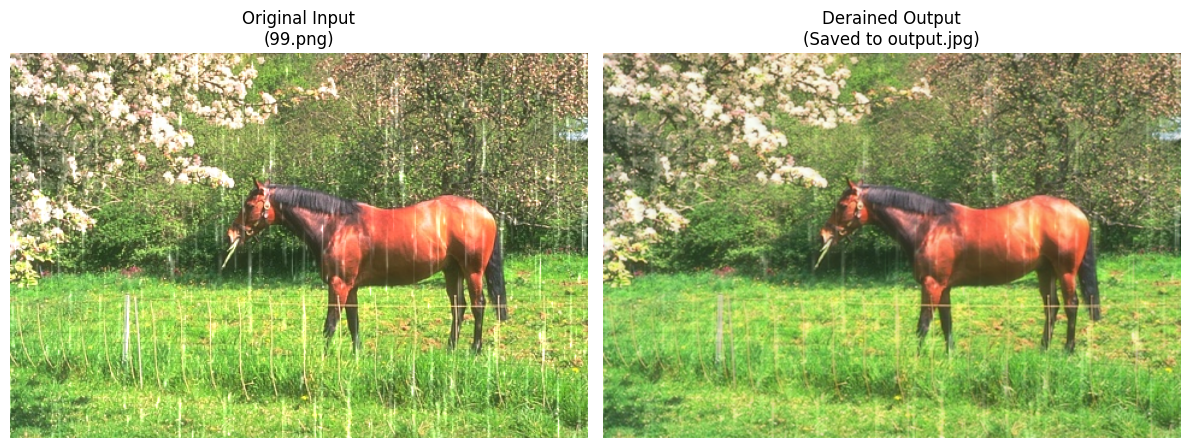


Script finished.


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
import numpy as np # Not strictly needed here unless calculating mean/std
import matplotlib.pyplot as plt # Import for displaying images

# ==============================================================================
# ==============================================================================
# >> MANDATORY STEP 1: INSERT YOUR TRAINED MODEL'S DEFINITION HERE <<
# ==============================================================================
# ==============================================================================
# This MUST be the SAME class definition as the model saved in MODEL_PATH.
# Replace the SimplePlaceholderDerainer below with your actual model class.
# ==============================================================================

class SimplePlaceholderDerainer(nn.Module): # <--- REPLACE THIS CLASS
    """
    This MUST match the architecture of the saved model weights.
    Replace this placeholder with your actual trained model's class definition.
    """
    def __init__(self, in_channels=3, out_channels=3, features=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, features, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(features, features, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(features, out_channels, kernel_size=3, padding=1)
        # Optional: Add Tanh if your model used it as the final activation
        # self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        identity = x
        x = self.relu2(self.conv2(x))
        # x = x + identity # Example skip connection
        x = self.conv3(x)
        # x = self.tanh(x) # Optional final activation
        return x

# ==============================================================================
# ==============================================================================


# ================== Configuration ==================
# --- Paths ---
MODEL_PATH = 'best_derain_model.pth' # Path to your saved model weights
INPUT_IMAGE_PATH = '99.png' # <--- CHANGE THIS
OUTPUT_IMAGE_PATH = 'output.jpg' # <--- CHANGE THIS

# --- Device ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# ==============================================================================
# >> MANDATORY STEP 2: VERIFY THESE NORMALIZATION VALUES <<
# ==============================================================================
# These MUST EXACTLY match the mean and std used during training!
# Incorrect values here WILL cause color distortion.
# ==============================================================================
TRAIN_MEAN = [0.5, 0.5, 0.5] # <--- VERIFY/CHANGE THIS
TRAIN_STD = [0.5, 0.5, 0.5]  # <--- VERIFY/CHANGE THIS
# ==============================================================================

# --- Preprocessing (MUST MATCH TRAINING) ---
TARGET_HEIGHT = 480
TARGET_WIDTH = 720

print(f"Using Normalization: Mean={TRAIN_MEAN}, Std={TRAIN_STD}")
TRANSFORM = transforms.Compose([
    transforms.Resize((TARGET_HEIGHT, TARGET_WIDTH)),
    transforms.ToTensor(), # Converts to [0, 1] range, shape [C, H, W]
    transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD) # Normalizes using your values
])

# Transformation to convert tensor back to PIL Image for saving
to_pil = transforms.ToPILImage()

# ================== Load Model ==================
# *** Replace 'SimplePlaceholderDerainer' below if you replaced the class definition above ***
MODEL_CLASS_NAME = DECTNet # <--- CHANGE THIS IF YOU REPLACED THE CLASS
print(f"Loading model architecture '{MODEL_CLASS_NAME.__name__}'...")

try:
    model = MODEL_CLASS_NAME().to(DEVICE)
except NameError:
    print(f"\n!!! ERROR: The model class '{MODEL_CLASS_NAME.__name__}' is not defined above. !!!")
    print("!!! You MUST include the exact Python class definition for the saved model. !!!\n")
    exit()
except Exception as e:
    print(f"\n!!! An error occurred during model initialization: {e} !!!\n")
    exit()

print(f"Loading model weights from: {MODEL_PATH}")
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
except FileNotFoundError:
    print(f"\n!!! ERROR: Model file not found at '{MODEL_PATH}' !!!")
    exit()
except RuntimeError as e:
    print(f"\n!!! ERROR loading model weights: {e} !!!")
    print("!!! Model definition likely mismatch with saved weights. !!!")
    exit()
except Exception as e:
    print(f"\n!!! An unexpected error occurred loading model weights: {e} !!!\n")
    exit()

model.eval()
print("Model loaded successfully.")

# ================== Load and Process Image ==================
print(f"Loading input image from: {INPUT_IMAGE_PATH}")
try:
    input_image_pil = Image.open(INPUT_IMAGE_PATH).convert('RGB') # Keep the original PIL image
except FileNotFoundError:
    print(f"\n!!! ERROR: Input image not found at '{INPUT_IMAGE_PATH}' !!!")
    exit()
except Exception as e:
    print(f"\n!!! ERROR loading input image: {e} !!!\n")
    exit()

print("Preprocessing image...")
input_tensor = TRANSFORM(input_image_pil)
input_batch = input_tensor.unsqueeze(0).to(DEVICE)

# ================== Perform Deraining (Inference) ==================
print("Performing inference...")
with torch.no_grad():
    try:
        output_batch = model(input_batch)
    except Exception as e:
        print(f"\n!!! ERROR during model inference (forward pass): {e} !!!\n")
        exit()

output_tensor = output_batch.squeeze(0).cpu()

# ================== Debugging: Inspect Raw Output ==================
print("\n--- Raw Model Output Tensor Stats (Before Denormalization) ---")
print(f"  Shape: {output_tensor.shape}")
print(f"  Min value: {output_tensor.min().item():.4f}")
print(f"  Max value: {output_tensor.max().item():.4f}")
print(f"  Mean value: {output_tensor.mean().item():.4f}")
print(f"  Std value: {output_tensor.std().item():.4f}")
print("--- End Raw Stats ---")
# ==================================================================

# ================== Post-process and Save Output ==================
print("\nPost-processing output (Denormalizing)...")
mean = torch.tensor(TRAIN_MEAN).view(3, 1, 1)
std = torch.tensor(TRAIN_STD).view(3, 1, 1)
output_denormalized = output_tensor * std + mean
output_clamped = torch.clamp(output_denormalized, 0, 1)

print("Converting tensor to PIL Image...")
try:
    output_image_pil = to_pil(output_clamped) # Keep the final PIL image
except Exception as e:
    print(f"\n!!! ERROR converting output tensor to PIL Image: {e} !!!\n")
    exit()

print(f"Saving derained image to: {OUTPUT_IMAGE_PATH}")
try:
    output_dir = os.path.dirname(OUTPUT_IMAGE_PATH)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    output_image_pil.save(OUTPUT_IMAGE_PATH)
    print("Derained image saved successfully!")
except Exception as e:
    print(f"\n!!! ERROR saving output image: {e} !!!\n")

# ================== Display Input and Output Images ==================
print("\nDisplaying input and output images...")
try:
    # Create a figure with two subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Adjust figsize as needed

    # Display the original input image
    axes[0].imshow(input_image_pil)
    axes[0].set_title(f"Original Input\n({os.path.basename(INPUT_IMAGE_PATH)})")
    axes[0].axis('off') # Hide axes ticks

    # Display the derained output image
    axes[1].imshow(output_image_pil)
    axes[1].set_title(f"Derained Output\n(Saved to {os.path.basename(OUTPUT_IMAGE_PATH)})")
    axes[1].axis('off') # Hide axes ticks

    plt.tight_layout() # Adjust layout to prevent titles overlapping
    plt.show() # Show the plot window

except Exception as e:
    print(f"\n!!! ERROR displaying images using matplotlib: {e} !!!")
    print("!!! Ensure matplotlib is installed (`pip install matplotlib`) and your environment supports GUI display. !!!\n")


print("\nScript finished.")